# L1: Haystack Building Blocks

<p style="background-color:#fff6e4; padding:15px; border-width:3px; border-color:#f5ecda; border-style:solid; border-radius:6px"> ⏳ <b>Note <code>(Kernel Starting)</code>:</b> This notebook takes about 30 seconds to be ready to use. You may start and watch the video while you wait.</p>

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
from helper import load_env
load_env()

<p style="background-color:#fff6ff; padding:15px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px"> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>. For more help, please see the <em>"Appendix - Tips and Help"</em> Lesson.</p>

> **Note**: At time of recording, we are using haystack-ai==2.2.4 

To build any sort of AI application with Haystack, we combine Components [[+]](https://docs.haystack.deepset.ai/docs/components?utm_campaign=developer-relations&utm_source=dlai) into full Pipelines [[+]](https://docs.haystack.deepset.ai/docs/pipelines?utm_campaign=developer-relations&utm_source=dlai).

## Components

In [4]:
from haystack.components.embedders import OpenAIDocumentEmbedder

embedder = OpenAIDocumentEmbedder(model="text-embedding-3-small")

In [5]:
embedder

Inputs:
  - documents: List[Document]
Outputs:
  - documents: List[Document]
  - meta: Dict[str, Any]

In [6]:
from haystack.dataclasses import Document

documents = [Document(content="Haystack is an open source AI framework to build full AI applications in Python"),
             Document(content="You can build AI Pipelines by combining Components"),]

embedder.run(documents=documents)

Calculating embeddings: 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


{'documents': [Document(id=cca6283a4f41557c49df1c5087a6be0ec172815a8d0c811e435caf6b1a93e0b4, content: 'Haystack is an open source AI framework to build full AI applications in Python', embedding: vector of size 1536),
  Document(id=11ee1490e1dc5cd44361b1541008891b0b40aabd4d5bb2da6a2499f23e6120f7, content: 'You can build AI Pipelines by combining Components', embedding: vector of size 1536)],
 'meta': {'model': 'text-embedding-3-small',
  'usage': {'prompt_tokens': 24, 'total_tokens': 24}}}

## Pipelines
### Initialize a Document Store

Check out other available [Document Stores](https://docs.haystack.deepset.ai/docs/document-store?utm_campaign=developer-relations&utm_source=dlai). In this example, we will use the simplest document store that has no setup requirements, the [`InMemoryDocumentStore`](https://docs.haystack.deepset.ai/docs/inmemorydocumentstore?utm_campaign=developer-relations&utm_source=dlai).


In [7]:
from haystack.document_stores.in_memory import InMemoryDocumentStore

document_store = InMemoryDocumentStore()

### Writing documents with embeddings into a document store


In [8]:
from haystack import Pipeline

from haystack.components.converters.txt import TextFileToDocument
from haystack.components.preprocessors.document_splitter import DocumentSplitter
from haystack.components.embedders import OpenAIDocumentEmbedder
from haystack.components.writers import DocumentWriter

converter = TextFileToDocument() # Document is a type
splitter = DocumentSplitter() # This is the chunker. By default, it splits by 200 words
# splitter = DocumentSplitter(split_by="passage")
embedder = OpenAIDocumentEmbedder()
writer = DocumentWriter(document_store=document_store)

indexing_pipeline = Pipeline()

# The first argument is the component name. It can be anything.
indexing_pipeline.add_component("converter", converter)
indexing_pipeline.add_component("splitter", splitter)
indexing_pipeline.add_component("embedder", embedder)
indexing_pipeline.add_component("writer", writer)

#### Connecting Components

In [9]:
indexing_pipeline.connect("converter", "splitter") # converter output = splitter input
indexing_pipeline.connect("splitter", "embedder")
indexing_pipeline.connect("embedder", "writer")

🚅 Components
  - converter: TextFileToDocument
  - splitter: DocumentSplitter
  - embedder: OpenAIDocumentEmbedder
  - writer: DocumentWriter
🛤️ Connections
  - converter.documents -> splitter.documents (List[Document])
  - splitter.documents -> embedder.documents (List[Document])
  - embedder.documents -> writer.documents (List[Document])

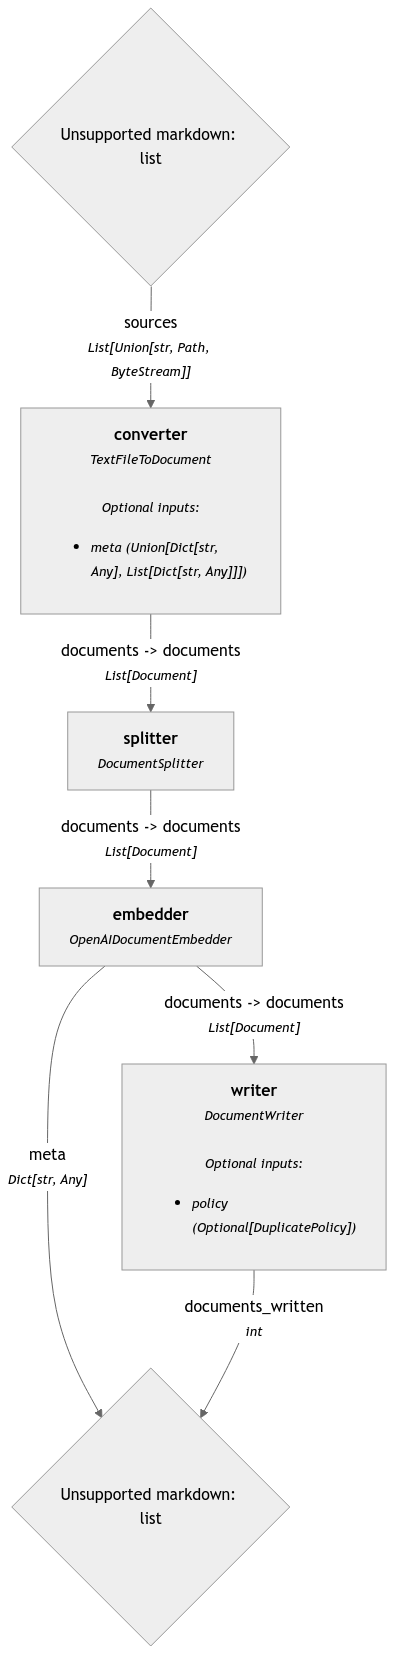

In [10]:
indexing_pipeline.show()

#### Running Pipelines


In [11]:
indexing_pipeline.run({"converter": {"sources": ['data/davinci.txt']}})

Calculating embeddings: 100%|██████████| 2/2 [00:01<00:00,  1.13it/s]


{'embedder': {'meta': {'model': 'text-embedding-ada-002-v2',
   'usage': {'prompt_tokens': 14631, 'total_tokens': 14631}}},
 'writer': {'documents_written': 47}}

In [13]:
print(document_store.filter_documents()[5].content)

Leonardo's achievements it is necessary to
regard him as a scientist quite as much as an artist, as a philosopher
no less than a painter, and as a draughtsman rather than a colourist.
There is hardly a branch of human learning to which he did not at
one time or another give his eager attention, and he was engrossed in
turn by the study of architecture--the foundation-stone of all true
art--sculpture, mathematics, engineering and music. His versatility
was unbounded, and we are apt to regret that this many-sided genius
did not realise that it is by developing his power within certain
limits that the great master is revealed. Leonardo may be described as
the most Universal Genius of Christian times-perhaps of all time.

[Illustration: PLATE III.-THE VIRGIN OF THE ROCKS

In the National Gallery. No. 1093. 6 ft. ½ in. h. by 3 ft 9 ½ in. w.
(1.83 x 1.15)

This picture was painted in Milan about 1495 by Ambrogio da Predis
under the supervision and guidance of Leonardo da Vinci, the
essential

### Creating a document search pipeline

In [14]:
from haystack.components.embedders import OpenAITextEmbedder
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever

query_embedder = OpenAITextEmbedder()
retriever = InMemoryEmbeddingRetriever(document_store=document_store)

document_search = Pipeline()

document_search.add_component("query_embedder", query_embedder)
document_search.add_component("retriever", retriever)

# document_search.connect("query_embedder", "retriever")
document_search.connect("query_embedder.embedding", "retriever.query_embedding")

🚅 Components
  - query_embedder: OpenAITextEmbedder
  - retriever: InMemoryEmbeddingRetriever
🛤️ Connections
  - query_embedder.embedding -> retriever.query_embedding (List[float])

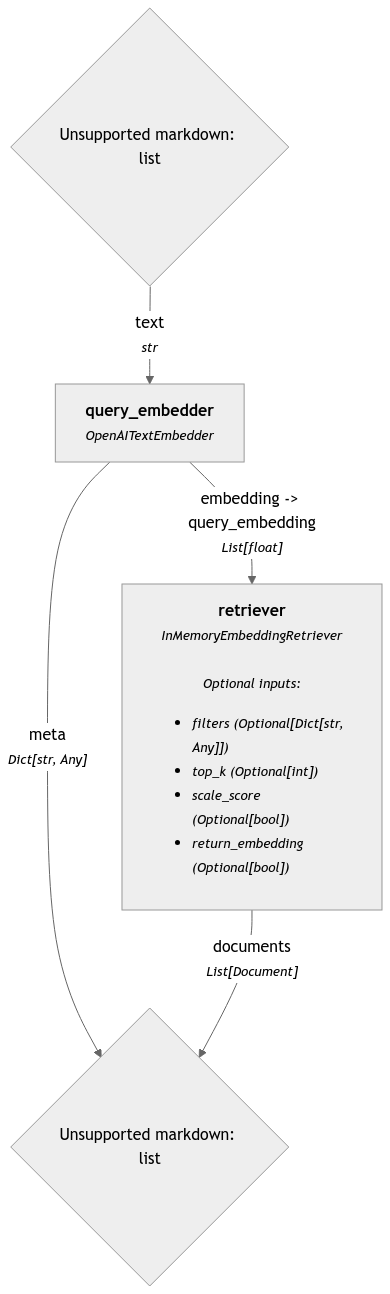

In [15]:
document_search.show()

In [16]:
question = "How old was Davinci when he died?"

results = document_search.run({"query_embedder": {"text": question}})

for i, document in enumerate(results["retriever"]["documents"]):
    print("\n--------------\n")
    print(f"DOCUMENT {i}")
    print(document.content)


--------------

DOCUMENT 0
CHRIST, AND ST. ANNE

In the Louvre. No. 1508. 5 ft. 7 in. h. by 4 ft. 3 in. w. (1.70 x
1.29)

Painted between 1509 and 1516 with the help of assistants.]

On October 10, 1516, when he was resident at the Manor House of Cloux
near Amboise in Touraine with Francesco Melzi, his friend and
assistant, he showed three of his pictures to the Cardinal of Aragon,
but his right hand was now paralysed, and he could "no longer colour
with that sweetness with which he was wont, although still able to
make drawings and to teach others."

It was no doubt in these closing years of his life that he drew the
"Portrait of Himself" in red chalk, now at Turin, which is probably
the only authentic portrait of him in existence.



HIS DEATH

On April 23, 1519--Easter Eve--exactly forty-five years before the
birth of Shakespeare, Leonardo da Vinci made his will, and on May 2 of
the same year he passed away.

Vasari informs us that Leonardo, "having become old, lay sick for many
mo

In [17]:
question = "How old was Davinci when he died?"

results = document_search.run({"query_embedder": {"text": question},
                               "retriever": {"top_k": 3}})

for i, document in enumerate(results["retriever"]["documents"]):
    print("\n--------------\n")
    print(f"DOCUMENT {i}")
    print(document.content)


--------------

DOCUMENT 0
CHRIST, AND ST. ANNE

In the Louvre. No. 1508. 5 ft. 7 in. h. by 4 ft. 3 in. w. (1.70 x
1.29)

Painted between 1509 and 1516 with the help of assistants.]

On October 10, 1516, when he was resident at the Manor House of Cloux
near Amboise in Touraine with Francesco Melzi, his friend and
assistant, he showed three of his pictures to the Cardinal of Aragon,
but his right hand was now paralysed, and he could "no longer colour
with that sweetness with which he was wont, although still able to
make drawings and to teach others."

It was no doubt in these closing years of his life that he drew the
"Portrait of Himself" in red chalk, now at Turin, which is probably
the only authentic portrait of him in existence.



HIS DEATH

On April 23, 1519--Easter Eve--exactly forty-five years before the
birth of Shakespeare, Leonardo da Vinci made his will, and on May 2 of
the same year he passed away.

Vasari informs us that Leonardo, "having become old, lay sick for many
mo

**Next: Try changing the `top_k` for the retriever, or change the question:**
- Where was Davinci born?
- When did Davinci live in Rome?

In [18]:
question = "Where was Davinci born?"

results = document_search.run({"query_embedder": {"text": question},
                               "retriever": {"top_k": 3}})

for i, document in enumerate(results["retriever"]["documents"]):
    print("\n--------------\n")
    print(f"DOCUMENT {i}")
    print(document.content)


--------------

DOCUMENT 0
 In the Louvre




HIS BIRTH

Leonardo Da Vinci, the many-sided genius of the Italian Renaissance,
was born, as his name implies, at the little town of Vinci, which is
about six miles from Empoli and twenty miles west of Florence. Vinci
is still very inaccessible, and the only means of conveyance is the
cart of a general carrier and postman, who sets out on his journey
from Empoli at sunrise and sunset. Outside a house in the middle of
the main street of Vinci to-day a modern and white-washed bust of the
great artist is pointed to with much pride by the inhabitants.
Leonardo's traditional birthplace on the outskirts of the town still
exists, and serves now as the headquarters of a farmer and small wine
exporter.

Leonardo di Ser Piero d'Antonio di Ser Piero di Ser Guido da
Vinci--for that was his full legal name--was the natural and
first-born son of Ser Piero, a country notary, who, like his father,
grandfather, and great-grandfather, followed that honourab